# LowProFool
## Adversarial examples generation on the german credit dataset

### Imports

In [1]:
# Misc
import random
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm
import math
import os
import time
import sys
from ipykernel import kernelapp as app

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Keras 
import keras

Using TensorFlow backend.
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/liuyue/

In [5]:
# Helpers
from Adverse import lowProFool, deepfool
from Metrics import *

### Notebook config

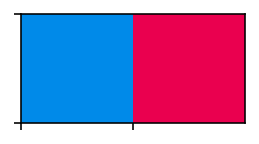

In [6]:
# Retina display
%config InlineBackend.figure_format ='retina'
pd.set_option('display.max_columns', 500)
tqdm.pandas()
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

ccolors = ["#008ae9", "#ea004f"]
sns.set_palette(ccolors)
sns.palplot(sns.color_palette())

### Constants

In [7]:
SEED = 0
DATASET = 'credit-g'
df = pd.read_csv('./spambase.data',header=None)

### Fetch data from openml

### Preprocess data

In [8]:
def normalize(df, target, feature_names, bounds):
    df_return = df.copy()
    
    # Makes sure target does not need scaling
    targets = np.unique(df[target].values)
    assert(len(targets == 2) and 0. in targets and 1. in targets)
    
    scaler = MinMaxScaler()
    X = df_return[feature_names]
    scaler.fit(X)    
    df_return[feature_names] = scaler.transform(X)
    
    lower_bounds = scaler.transform([bounds[0]])
    upper_bounds = scaler.transform([bounds[1]])

    return scaler, df_return, (lower_bounds[0], upper_bounds[0])

def get_weights(df, target, show_heatmap=False):
    def heatmap(cor):
        plt.figure(figsize=(8,6))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()

    cor = df.corr()
    cor_target = abs(cor[target])

    weights = cor_target[:-1] #removing target WARNING ASSUMES TARGET IS LAST
    weights = weights / np.linalg.norm(weights)

    if show_heatmap:
        heatmap(cor)
            
    return weights.values

def balance_df(df):
    len_df_0, len_df_1 = len(df[df[target] == 0.]), len(df[df[target] == 1.])
    df_0 = df[df[target] == 0.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df_1 = df[df[target] == 1.].sample(min(len_df_0, len_df_1), random_state=SEED)
    df = pd.concat((df_0, df_1))
    return df

def get_bounds():
    low_bounds = df_orig.min().values
    up_bounds = df_orig.max().values
    
    #removing target WARNING ASSUMES TARGET IS LAST
    low_bounds = low_bounds[:-1]
    up_bounds = up_bounds[:-1]
    
    return [low_bounds, up_bounds]

def split_train_test_valid():
    # Train test splits
    df_train, df_test = train_test_split(df, test_size=300, shuffle=True, random_state=SEED)
    df_test, df_valid = train_test_split(df_test, test_size=100, shuffle=True, random_state=SEED)
    
    return df_train, df_test, df_valid

### Training neural net

In [9]:
def get_model(conf, load=False):
#     assert(conf['Dataset'] == 'credit-g')
    
    class GermanNet(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(GermanNet, self).__init__()
            self.linear1 = torch.nn.Linear(D_in, H)
            self.linear2 = torch.nn.Linear(H, H)
            self.linear3 = torch.nn.Linear(H, D_out)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=0)

        def forward(self, x):
            h1 = self.relu(self.linear1(x))
            h2 = self.relu(self.linear2(h1))
            h3 = self.relu(self.linear2(h2))
            h4 = self.relu(self.linear2(h3))
            h5 = self.relu(self.linear2(h4))
            h6 = self.relu(self.linear2(h5))
            a3 = self.linear3(h6)
            y = self.softmax(a3)
            return y

    def train(model, criterion, optimizer, X, y, N, n_classes):
        model.train()

        current_loss = 0
        current_correct = 0


        # Training in batches
        for ind in range(0, X.size(0), N):
            indices = range(ind, min(ind + N, X.size(0)) - 1) 
            inputs, labels = X[indices], y[indices]
            inputs = Variable(inputs, requires_grad=True)


            optimizer.zero_grad()

            output = model(inputs)
            _, indices = torch.max(output, 1) # argmax of output [[0.61, 0.12]] -> [0]
            # [[0, 1, 1, 0, 1, 0, 0]] -> [[1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
            preds = torch.tensor(keras.utils.to_categorical(indices, num_classes=n_classes))

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            current_correct += (preds.int() == labels.int()).sum() /n_classes


        current_loss = current_loss / X.size(0)
        current_correct = current_correct.double() / X.size(0)    

        return preds, current_loss, current_correct.item()
    
    df = conf['TrainData']
    target = conf['Target']
    feature_names = conf['FeatureNames']
                        
    n_classes = len(np.unique(df[target]))
    X_train = torch.FloatTensor(df[feature_names].values)
    y_train = keras.utils.to_categorical(df[target], n_classes)
    y_train = torch.FloatTensor(y_train)

    D_in = X_train.size(1)
    D_out = y_train.size(1)

    epochs = 400
    batch_size = 100
    H = 100
    net = GermanNet(D_in, H, D_out)

    lr = 1e-4    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        preds, epoch_loss, epoch_acc = train(net, criterion, optimizer, X_train, y_train, batch_size, n_classes)     
        if (epoch % 50 == 0):
            print("> epoch {:.0f}\tLoss {:.5f}\tAcc {:.5f}".format(epoch, epoch_loss, epoch_acc))

    net.eval()
    
    return net

### Generate adversarial examples

In [10]:
def gen_adv(config, method):
    df_test = config['TestData']
    extra_cols = ['orig_pred', 'adv_pred', 'iters']    
    model = config['Model']
    weights = config['Weights']
    bounds = config['Bounds']
    maxiters = config['MaxIters']
    alpha = config['Alpha']
    lambda_ = config['Lambda']
    
    results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
            
    i = -1
    
    for _, row in tqdm(df_test.iterrows(), total=df_test.shape[0], desc="{}".format(method)):
        
        i += 1
        
        x_tensor = torch.FloatTensor(row[config['FeatureNames']])   
        
        if method == 'LowProFool':
            orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, bounds,
                                                             maxiters, alpha, lambda_)
        elif method == 'Deepfool':
            orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, maxiters, alpha,
                                                          bounds, weights=[])
        else:
            raise Exception("Invalid method", method)
        results[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
        
    return pd.DataFrame(results, index=df_test.index, columns = feature_names + extra_cols)

In [15]:
# lowProFool attack 
from tqdm import tqdm_notebook
df_test = config['TestData']
extra_cols = ['orig_pred', 'adv_pred', 'iters']    
model = config['Model']
weights = config['Weights']
bounds = config['Bounds']
maxiters = config['MaxIters']
alpha = config['Alpha']
lambda_ = config['Lambda']
extra_cols = ['orig_pred', 'adv_pred', 'iters']    
results = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
method = 'LowProFool'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
i = -1

for _, row in df_test.iterrows():
    i += 1
    x_tensor = torch.FloatTensor(row[config['FeatureNames']])
    orig_pred, adv_pred, x_adv, loop_i = lowProFool(x_tensor, model, weights, bounds,maxiters, alpha, lambda_)
    results[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
df_adv_lpf = pd.DataFrame(results, index=df_test.index)
results.shape

(200, 60)

In [34]:
config['TrainData']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
2983,0.000000,0.000000,0.384314,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196,0.000000,0.000,0.000000,0.000000,0.104533,0.000000,0.176418,0.0,0.000000,0.0000,0.000,0.000000,0.000000,0.0,0.137255,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001037,0.001001,0.001831,0.0
2951,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.287417,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.652,0.000000,0.000000,0.0,0.000000,0.911765,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.347773,0.001037,0.000701,0.003725,0.0
1398,0.000000,0.000000,0.152941,0.0,0.101430,0.000000,0.071527,0.046805,0.000000,0.137748,0.000000,0.026887,0.281081,0.000,0.176871,0.000,0.000000,0.171617,0.110933,0.000000,0.140414,0.0,0.095413,0.0000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.109244,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.008203,0.000000,0.023156,0.066967,0.000000,0.001280,0.001802,0.015152,1.0
4324,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.355200,0.000000,0.000000,0.0,0.000000,0.0000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000568,0.0
3694,0.000000,0.000000,0.000000,0.0,0.262679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181982,0.000,0.000000,0.000,0.000000,0.000000,0.053867,0.000000,0.000000,0.0,0.000000,0.0000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.121248,0.0,0.000000,0.0,0.0,0.037856,0.017022,0.059777,0.000000,0.000000,0.000000,0.000389,0.000501,0.002462,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.484800,0.000000,0.000000,0.0,0.000000,0.0000,0.000,0.000000,0.272727,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000253,0.0
1073,0.354626,0.000000,0.000000,0.0,0.418726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.040,0.000000,0.000000,0.171733,0.000000,0.144914,0.0,0.000000,0.0000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.158416,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026711,0.000000,0.000000,0.001733,0.001902,0.003977,1.0
3910,0.000000,0.000000,0.058824,0.0,0.079324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.042017,0.000000,0.048533,0.000000,0.027003,0.0,0.000000,0.0000,0.122,0.042717,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.059406,0.44186,0.0,0.000000,0.0,0.0,0.170868,0.073229,0.0,0.000000,0.0,0.0,0.068643,0.004409,0.015484,0.000000,0.014326,0.000000,0.001054,0.001802,0.014268,0.0
1397,0.136564,0.043417,0.000000,0.0,0.000000,0.316327,0.000000,0.000000,0.000000,0.000000,0.000000,0.064116,0.111712,0.

In [12]:
feature_names = df.columns.values[:-1]
extra_cols = np.array([57, 58, 59])
columns = np.concatenate((feature_names, extra_cols), axis = 0)

In [13]:
# DeepFool attack 
from tqdm import tqdm_notebook
df_test = config['TestData']
extra_cols = ['orig_pred', 'adv_pred', 'iters']    
model = config['Model']
weights = config['Weights']
bounds = config['Bounds']
maxiters = config['MaxIters']
alpha = config['Alpha']
lambda_ = config['Lambda']
extra_cols = ['orig_pred', 'adv_pred', 'iters']    
results_ = np.zeros((len(df_test), len(feature_names) + len(extra_cols)))    
method = 'Deepfool'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
i = -1

for _, row in df_test.iterrows():
    i += 1
    x_tensor = torch.FloatTensor(row[config['FeatureNames']])
    orig_pred, adv_pred, x_adv, loop_i = deepfool(x_tensor, model, weights=weights, bounds=bounds,maxiters=maxiters, alpha=alpha, overshoot=lambda_)
    results_[i] = np.concatenate((x_adv, [orig_pred, adv_pred, loop_i]), axis=0)
df_adv_df = pd.DataFrame(results_, index=df_test.index)

NameError: name 'config' is not defined

In [37]:
list_metrics = {'SuccessRate' : True,
                'iter_means': False,
                'iter_std': False,
                'normdelta_median': False,
                'normdelta_mean': True,
                'n_std': True,
                'weighted_median': False,
                'weighted_mean': True,
                'w_std': True,
                'mean_dists_at_org': False,
                'median_dists_at_org': False,
                'mean_dists_at_tgt': False,
                'mean_dists_at_org_weighted': True,
                'mdow_std': True,
                'median_dists_at_org_weighted': False,
                'mean_dists_at_tgt_weighted': True,
                'mdtw_std': True,
                'prop_same_class_arg_org': False,
                'prop_same_class_arg_adv': False}
config['AdvData'] = {'LowProFool' : df_adv_lpf, 'Deepfool' : df_adv_df}
all_metrics = get_metrics(config, list_metrics)

all_metrics = pd.DataFrame(all_metrics, columns=['Method'] + [k for k, v in list_metrics.items() if v])

/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/liuyue/opt/anaconda3/envs/lab/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=2

In [14]:
# Load initial dataset
# df_orig, target, feature_names = get_df(DATASET)


feature_names = df.columns.values[:-1]
target = 57
df = df.astype(float)
df_orig = df


# Balance dataset classes
df = balance_df(df_orig)

# Compute the bounds for clipping
bounds = get_bounds()

# Normalize the data
scaler, df, bounds = normalize(df, target, feature_names, bounds)

# Compute the weihts modelizing the expert's knowledge
weights = get_weights(df, target)

# Split df into train/test/valid
df_train, df_test, df_valid = split_train_test_valid()

# Build experimenation config
config = {'Dataset'     : 'credit-g',
         'MaxIters'     : 20000,
         'Alpha'        : 0.001,
         'Lambda'       : 8.5,
         'TrainData'    : df_train,
         'TestData'     : df_test,
         'ValidData'    : df_valid,
         'Scaler'       : scaler,
         'FeatureNames' : feature_names,
         'Target'       : target,
         'Weights'      : weights,
         'Bounds'       : bounds}

# Train neural network
model = get_model(config)
config['Model'] = model

# Compute accuracy on test set
y_true = df_test[target]
x_test = torch.FloatTensor(df_test[feature_names].values)
y_pred = model(x_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
print("Accuracy score on test data", accuracy_score(y_true, y_pred))
    
# Sub sample
config['TestData'] = config['TestData'].sample(n=200, random_state = SEED)


> epoch 0	Loss 0.02334	Acc 0.68912
> epoch 50	Loss 0.02052	Acc 0.94408
> epoch 100	Loss 0.02032	Acc 0.96091
> epoch 150	Loss 0.02015	Acc 0.96903
> epoch 200	Loss 0.02003	Acc 0.97685
> epoch 250	Loss 0.01997	Acc 0.98046
> epoch 300	Loss 0.01993	Acc 0.98286
> epoch 350	Loss 0.01993	Acc 0.98046
Accuracy score on test data 0.94


In [39]:
plot_ratios

,Success Rate Ratio,Mean Perturbation Ratio,Dataset
0,97.395833,1595.452059,spambase


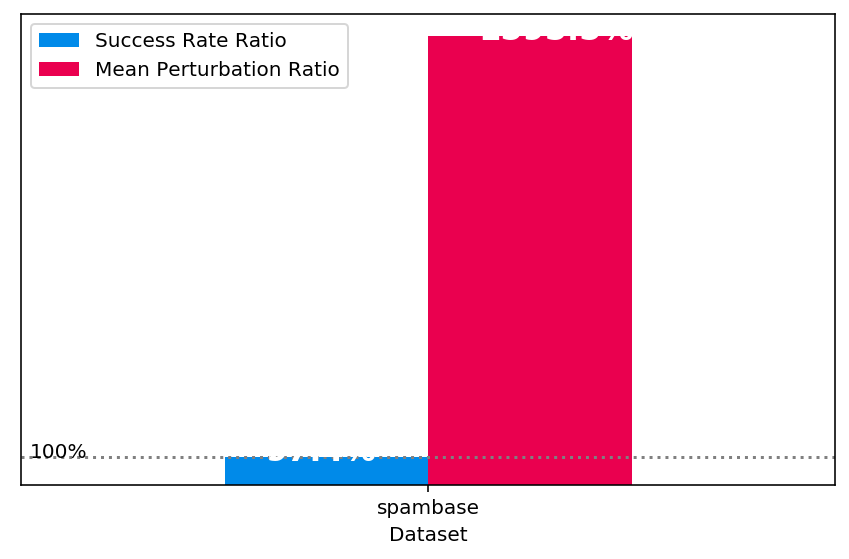

In [38]:
plot_ratios = []

m_lpf = all_metrics[all_metrics.Method == 'LowProFool']
m_df = all_metrics[all_metrics.Method =='Deepfool']

sr = m_lpf.SuccessRate.values / m_df.SuccessRate.values 
wm =  m_lpf.weighted_mean.values / m_df.weighted_mean.values 

plot_ratios.append([100*sr[0], 100*wm[0]])
plot_ratios = pd.DataFrame(plot_ratios, columns=['Success Rate Ratio', 'Mean Perturbation Ratio'])
plot_ratios['Dataset'] = 'spambase'

f = plt.figure()
ax = plt.axes()
plot_ratios.plot(x='Dataset', kind='bar', legend=True, ax=ax)

for i, v in enumerate(plot_ratios['Success Rate Ratio'].values):
    ax.text(i - 0.2, v - 12 , str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')
for i, v in enumerate(plot_ratios['Mean Perturbation Ratio'].values):
    ax.text(i + 0.062, v - 12, str(v.round(1)) + '%', fontsize=16, color='white', weight='bold')

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
ax.axhline(100, ls=':', c='grey')
ax.text(-0.49, 100 - 5, '100%')


ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Misc
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

# Clipping function
def clip(current, low_bound, up_bound):
    assert(len(current) == len(up_bound) and len(low_bound) == len(up_bound))
    low_bound = torch.FloatTensor(low_bound)
    up_bound = torch.FloatTensor(up_bound)
    clipped = torch.max(torch.min(current, up_bound), low_bound)
    return clipped


def lowProFool(x, model, weights, bounds, maxiters, alpha, lambda_):
    """3
    Generates an adversarial examples x' from an original sample x

    :param x: tabular sample
    :param model: neural network
    :param weights: feature importance vector associated with the dataset at hand
    :param bounds: bounds of the datasets with respect to each feature
    :param maxiters: maximum number of iterations ran to generate the adversarial examples
    :param alpha: scaling factor used to control the growth of the perturbation
    :param lambda_: trade off factor between fooling the classifier and generating imperceptible adversarial example
    :return: original label prediction, final label prediction, adversarial examples x', iteration at which the class changed
    """

    r = Variable(torch.FloatTensor(1e-4 * np.ones(x.numpy().shape)), requires_grad=True) 
    v = torch.FloatTensor(np.array(weights))
    
    output = model.forward(x + r)
    orig_pred = output.max(0, keepdim=True)[1].cpu().numpy()
    target_pred = np.abs(1 - orig_pred)
    
    target = [0., 1.] if target_pred == 1 else [1., 0.]
    target = Variable(torch.tensor(target, requires_grad=False)) 
    
    lambda_ = torch.tensor([lambda_])
    
    bce = nn.BCELoss()
    l1 = lambda v, r: torch.sum(torch.abs(v * r)) #L1 norm
    l2 = lambda v, r: torch.sqrt(torch.sum(torch.mul(v * r,v * r))) #L2 norm
    
    best_norm_weighted = np.inf
    best_pert_x = x
    
    loop_i, loop_change_class = 0, 0
    while loop_i < maxiters:
            
        zero_gradients(r)

        # Computing loss 
        loss_1 = bce(output, target)
        loss_2 = l2(v, r)
        loss = (loss_1 + lambda_ * loss_2)

        # Get the gradient
        loss.backward(retain_graph=True)
        grad_r = r.grad.data.cpu().numpy().copy()
        
        # Guide perturbation to the negative of the gradient
        ri = - grad_r
    
        # limit huge step
        ri *= alpha

        # Adds new perturbation to total perturbation
        r = r.clone().detach().cpu().numpy() + ri
        
        # For later computation
        r_norm_weighted = np.sum(np.abs(r * weights))
        
        # Ready to feed the model
        r = Variable(torch.FloatTensor(r), requires_grad=True) 
        
        # Compute adversarial example
        xprime = x + r
        
        # Clip to stay in legitimate bounds
        xprime = clip(xprime, bounds[0], bounds[1])
        
        # Classify adversarial example
        output = model.forward(xprime)
        output_pred = output.max(0, keepdim=True)[1].cpu().numpy()
        
        # Keep the best adverse at each iterations
        if output_pred != orig_pred and r_norm_weighted < best_norm_weighted:
            best_norm_weighted = r_norm_weighted
            best_pert_x = xprime

        if output_pred == orig_pred:
            loop_change_class += 1
            
        loop_i += 1 
        
    # Clip at the end no matter what
    best_pert_x = clip(best_pert_x, bounds[0], bounds[1])
    output = model.forward(best_pert_x)
    output_pred = output.max(0, keepdim=True)[1].cpu().numpy()

    return orig_pred, output_pred, best_pert_x.clone().detach().cpu().numpy(), loop_change_class 

# Forked from https://github.com/LTS4/DeepFool
def deepfool(x_old, net, maxiters, alpha, bounds, weights=[], overshoot=0.002):
    """
    :param image: tabular sample
    :param net: network 
    :param maxiters: maximum number of iterations ran to generate the adversarial examples
    :param alpha: scaling factor used to control the growth of the perturbation
    :param bounds: bounds of the datasets with respect to each feature
    :param weights: feature importance vector associated with the dataset at hand
    :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
    :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    
    input_shape = x_old.numpy().shape
    x = x_old.clone()
    x = Variable(x, requires_grad=True)
    
    output = net.forward(x)
    orig_pred = output.max(0, keepdim=True)[1] # get the index of the max log-probability

    origin = Variable(torch.tensor([orig_pred], requires_grad=False))

    I = []
    if orig_pred == 0:
        I = [0, 1]
    else:
        I = [1, 0]
        
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)
    
    k_i = origin
 
    loop_i = 0
    while torch.eq(k_i, origin) and loop_i < maxiters:
                
        # Origin class
        output[I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()
        
        # Target class
        zero_gradients(x)
        output[I[1]].backward(retain_graph=True)
        cur_grad = x.grad.data.numpy().copy()
            
        # set new w and new f
        w = cur_grad - grad_orig
        f = (output[I[1]] - output[I[0]]).data.numpy()

        pert = abs(f)/np.linalg.norm(w.flatten())
    
        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)   
        
        if len(weights) > 0:
            r_i /= np.array(weights)

        # limit huge step
        r_i = alpha * r_i / np.linalg.norm(r_i) 
            
        r_tot = np.float32(r_tot + r_i)
        
        
        pert_x = x_old + (1 + overshoot) * torch.from_numpy(r_tot)

        if len(bounds) > 0:
            pert_x = clip(pert_x, bounds[0], bounds[1])
                
        x = Variable(pert_x, requires_grad=True)
 
        output = net.forward(x)
        
        k_i = torch.tensor(np.argmax(output.data.cpu().numpy().flatten()))
                    
        loop_i += 1

    r_tot = (1+overshoot)*r_tot    
    pert_x = clip(pert_x, bounds[0], bounds[1])

    return orig_pred, k_i, pert_x.cpu(), loop_i

In [40]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


from lassonet import LassoNetClassifier

In [42]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
3802,0.000000,0.000000,0.098039,0.0,0.065020,0.000000,0.000000,0.000000,0.000000,0.066225,0.000000,0.104447,0.000000,0.000,0.000000,0.0000,0.070028,0.111111,0.108267,0.000000,0.273627,0.000000,0.000000,0.0000,0.076,0.035014,0.030303,0.111111,0.0,0.212185,0.0,0.0,0.0,0.0,0.212185,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.056501,0.000000,0.002875,0.000000,0.000000,0.002973,0.004405,0.015593,0.0
4359,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.266667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000379,0.0
3198,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.1515,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000316,0.0
2017,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.081749,0.000000,0.000000,0.224405,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.045867,0.000000,0.000000,0.000000,0.000000,0.0000,0.043,0.030112,0.000000,0.143014,0.0,0.000000,0.0,0.0,0.0,0.0,0.180672,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.025431,0.000000,0.000000,0.000000,0.000000,0.001016,0.001402,0.008902,0.0
4454,0.000000,0.000000,0.207843,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.113067,0.000000,0.190819,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.0,0.222689,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.148459,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011197,0.007209,0.010038,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,0.000000,0.005602,0.049020,0.0,0.109233,0.042517,0.011004,0.029703,0.000000,0.021192,0.030651,0.078594,0.000000,0.008,0.000000,0.0805,0.106443,0.036304,0.081067,0.018152,0.045005,0.049123,0.077064,0.0064,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.032510,0.015842,0.0,0.0,0.016807,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.004820,0.005402,0.027076,0.026154,0.016642,0.005699,0.029135,0.129040,1.0
1619,0.169604,0.026611,0.150980,0.0,0.000000,0.096939,0.000000,0.051305,0.218631,0.177483,0.000000,0.039297,0.068468,0.000,0.260771,0.0095,0.026611,0.211221,0.112533,0.063256,0.103510,0.000000,0.245872,0.0616,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.039916,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.006157,0.002769,0.000000,0.022895,0.031817,0.002723,0.012364,0.052463,0.058081,1.0
1291,0.000000,0.000000,0.000000,0.0,0.070221,0.045918,0.000000,0.145815,0.000000,0.214570,0.000000,0.000000,0.000000,0.000,0.122449,0.0000,0.000000,0.029703,0.115200,0.000000,0.243024,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.175553,0.000000,0.0,0.0,0.340336,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.003897,0.013684,0.024202,0.000000,0.000000,0.006301,0.006408,0.025505,1.0
102,0.000000,0.000000,0.000000,0.0,0.00

In [48]:
def load_mice():
#     df = pd.read_csv("./FAFS/spambase/spambase.data")
    # y = list(df[df.columns[57]].itertuples(False))
    y = list(df[df.columns[57]])
    classes = {lbl: i for i, lbl in enumerate(sorted(set(y)))}
    y = np.array([classes[lbl] for lbl in y])
    feats = df.columns[1:56]
    X = df[feats].fillna(df.groupby(y)[feats].transform("mean")).values
    X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
    return X, y


X, y = load_mice()

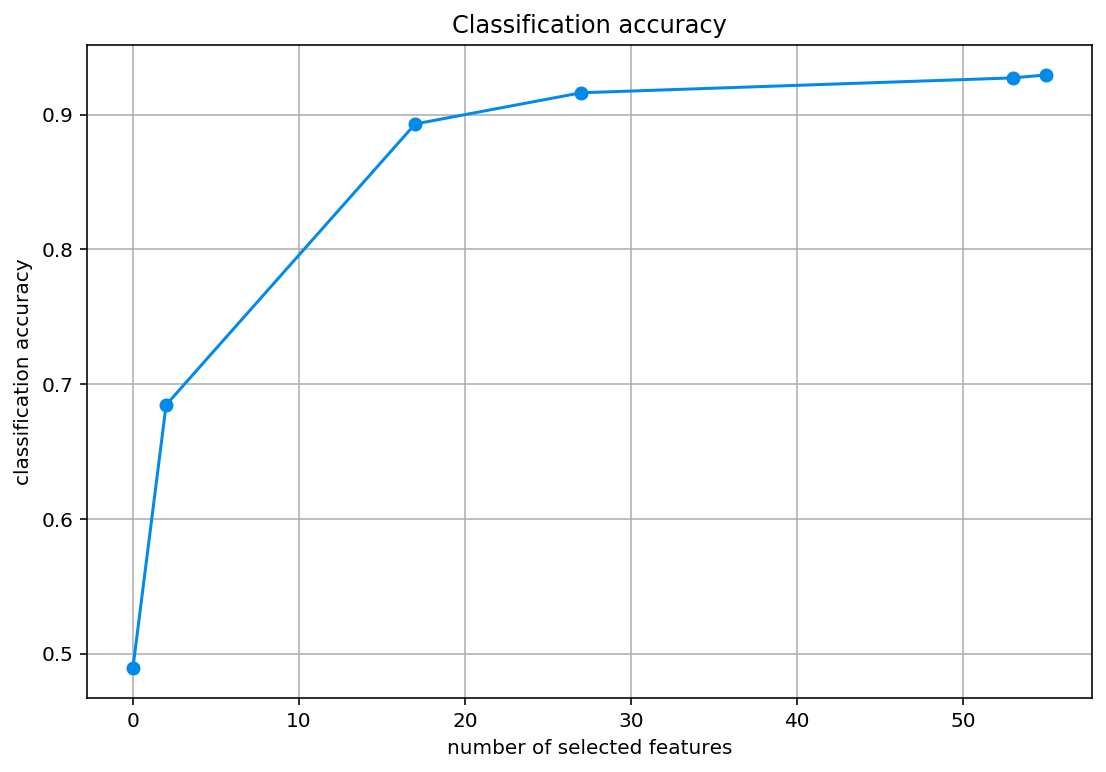

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LassoNetClassifier(eps_start=1e-3, lambda_start=1000)
path = model.path(X_train, y_train)

n_selected = []
accuracy = []

for save in path:
    model.load(save.state_dict)
    n_selected.append(save.selected.sum())
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(9, 6))
plt.grid(True)
plt.plot(n_selected, accuracy, "o-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")
plt.title("Classification accuracy")
plt.savefig("accuracy.png")
plt.show()

In [44]:
# df_adv_lpf
y = list(df_adv_lpf[df_adv_lpf.columns[57]])
classes = {lbl: i for i, lbl in enumerate(sorted(set(y)))}
y = np.array([classes[lbl] for lbl in y])
feats = df_adv_lpf.columns[1:56]
X = df_adv_lpf[feats].fillna(df_adv_lpf.groupby(y)[feats].transform("mean")).values
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

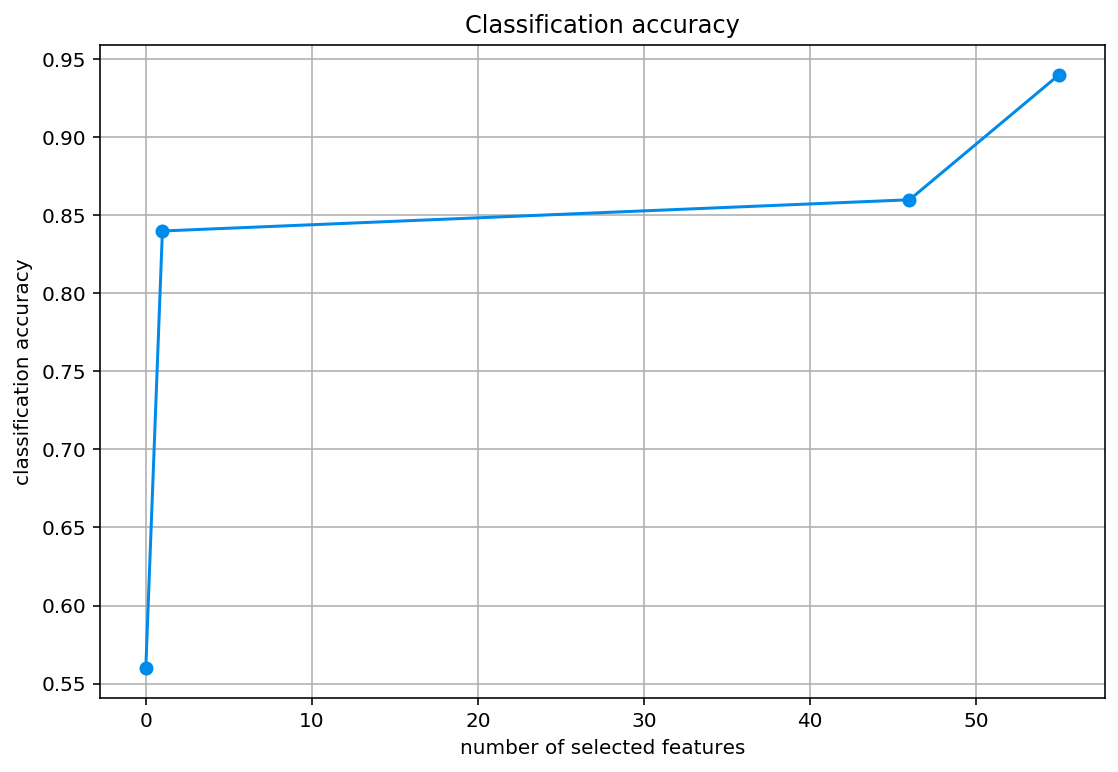

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LassoNetClassifier(eps_start=1e-3, lambda_start=1000)
path = model.path(X_train, y_train)

n_selected = []
accuracy = []

for save in path:
    model.load(save.state_dict)
    n_selected.append(save.selected.sum())
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(9, 6))
plt.grid(True)
plt.plot(n_selected, accuracy, "o-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")
plt.title("Classification accuracy")
plt.savefig("accuracy.png")
plt.show()

In [46]:
# df_adv_df
y = list(df_adv_df[df_adv_df.columns[57]])
classes = {lbl: i for i, lbl in enumerate(sorted(set(y)))}
y = np.array([classes[lbl] for lbl in y])
feats = df_adv_df.columns[1:56]
X = df_adv_df[feats].fillna(df_adv_df.groupby(y)[feats].transform("mean")).values
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

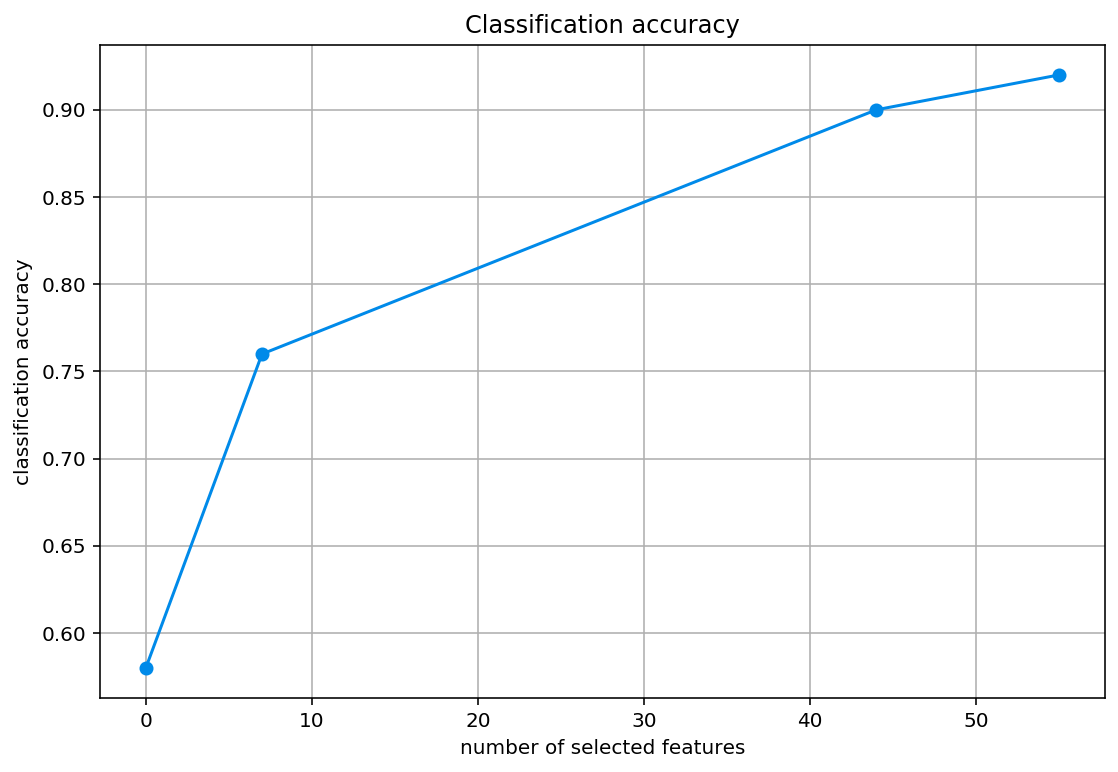

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LassoNetClassifier(eps_start=1e-3, lambda_start=1000)
path = model.path(X_train, y_train)

n_selected = []
accuracy = []

for save in path:
    model.load(save.state_dict)
    n_selected.append(save.selected.sum())
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(9, 6))
plt.grid(True)
plt.plot(n_selected, accuracy, "o-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")
plt.title("Classification accuracy")
plt.savefig("accuracy.png")
plt.show()

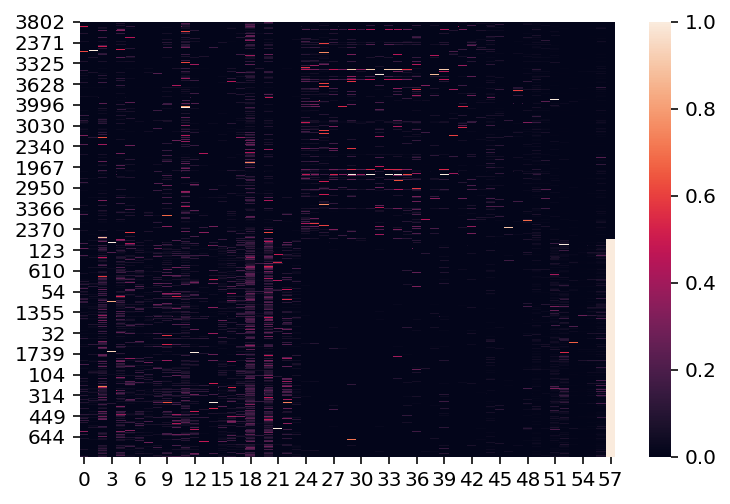

In [53]:
import seaborn as sns
sns.heatmap(df)

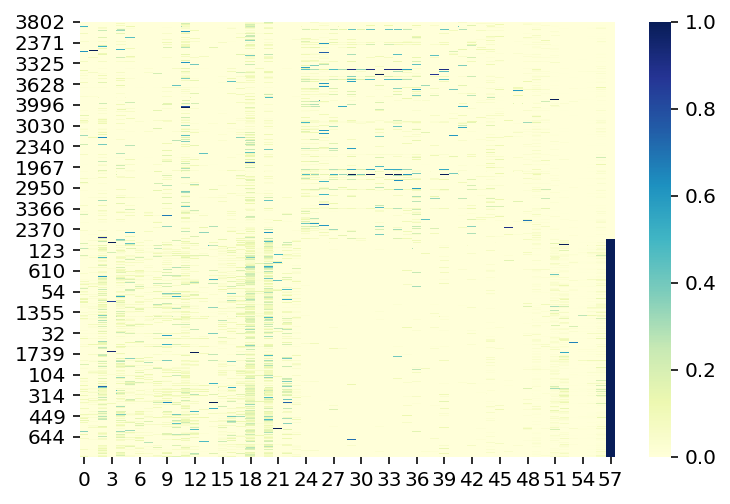

In [54]:
sns.heatmap(df,cmap="YlGnBu")

In [16]:
from secml.adv.attacks.poisoning import CAttackPoisoningLogisticRegression
from secml.adv.attacks.poisoning.tests import CAttackPoisoningTestCases
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.features.normalization import CNormalizerMinMax


class TestCAttackPoisoningLogisticRegression(CAttackPoisoningTestCases):
    """Unit test for CAttackPoisoningLogisticRegression."""

    def setUp(self):
        clf_params = {'C': 100, 'random_state': 42}
        self._set_up(clf_idx='logistic_regression',
                     poisoning_class=CAttackPoisoningLogisticRegression,
                     clf_class=CClassifierLogistic,
                     clf_params=clf_params)

    def test_poisoning_with_normalization_inside(self):
        """Test the CAttackPoisoning object when the classifier contains a
        normalizer.
        """
        normalizer = CNormalizerMinMax(feature_range=(-10, 10))

        self._test_clf_accuracy(normalizer)

        # test if the attack is effective and eventually show 2D plots
        self._test_attack_effectiveness(normalizer)

        self._test_single_poisoning_grad_check(normalizer)

    def test_poisoning_without_normalization_inside(self):
        """Test the CAttackPoisoning object when the classifier does not
        contains a normalizer.
        """

        self._test_clf_accuracy(normalizer=None)

        # test if the attack is effective and eventually show 2D plots
        self._test_attack_effectiveness(normalizer=None)

        self._test_single_poisoning_grad_check(normalizer=None)


if __name__ == '__main__':
    CAttackPoisoningTestCases.main()


ModuleNotFoundError: No module named 'secml.adv.attacks.poisoning.tests'